### Implementing Shor’s Algorithm End-to-End:  
## From Classical Order Finding to Real IBM Quantum Hardware  
By Carlos Araque L.
Data Engineer, IBM Qiskit Advocate  
Melbourne, Australia
2025


In [ ]:
cell_descriptions = {
    2: "Library check: verify required Python packages are installed.",
    3: "Detailed Qiskit environment and package versions check.",
    4: "Markdown: imports + classical helpers (order → factors).",
    5: "Classical helpers: recover order from measurement and Shor postprocess.",
    6: "Markdown: demo parameters (N=15) + sanity check.",
    7: "Set demo parameters N and a; check gcd(a, N).",
    8: "Markdown: build the unitary U(a) for modular multiplication.",
    9: "Construct U_mul_mod_N unitary for N=15 (n=4) and show dimension.",
    10: "Markdown: build QPE (order finding) with inverse QFT (iQFT).",
    11: "Build QPE circuit, attach controlled U powers, apply iQFT and measure.",
    12: "Markdown: optional local Aer test to validate the circuit.",
    13: "Run circuit on AerSimulator, get local counts and plot histogram.",
    14: "Markdown: IBM Hardware section — login/token guidance.",
    15: "Save IBM runtime account and instantiate QiskitRuntimeService.",
    16: "Markdown: choose a real backend (least_busy) with enough qubits.",
    17: "Select least_busy IBM backend with required qubits and print it.",
    18: "Markdown: transpile for the backend using preset pass manager.",
    19: "Generate preset pass manager, transpile qc, and report depth/2Q gates.",
    20: "Markdown: run on hardware with SamplerV2 + Session (example commented).",
    21: "Commented example showing Session+Sampler pattern (not used).",
    22: "Markdown: note that Sampler(mode=backend) is the key fix.",
    23: "Run SamplerV2 in job mode (Sampler(mode=backend)) and fetch result.",
    24: "Markdown: explain how to extract counts from SamplerV2 results.",
    25: "Extract counts from pub.data.c and print top hardware outcomes.",
    26: "Markdown: recover r from hardware + factor N explanation.",
    27: "Postprocess top outcomes to recover r and compute factors; print result.",
    28: "Markdown: practical loop for automatic retries (change t or shots).",
    29: "run_hw_attempt: build, select backend, transpile, run sampler, try recover factors; loop 3 attempts.",
    30: "Markdown: tweak — try multiple 'a' values automatically for better success.",
    31: "Loop over candidate a values (2,7,11,13) and run attempts until factoring succeeds."
}

print("Cell descriptions for cells 2–31 created.")

In [2]:

# Librry check script
import importlib

def check_package(pkg_name):
    try:
        importlib.import_module(pkg_name)
        print(f"✓ '{pkg_name}' está instalado.")
        return True
    except ImportError:
        print(f"✗ '{pkg_name}' NO está instalado.")
        return False


# Lista de librerías a validar
paquetes = [
    "requests",
    "qiskit",
    "qiskit_aer",           # nombre correcto para importar
    "qiskit_ibm_runtime",   # nombre correcto para importar
    "matplotlib"
]

# Validación
for pkg in paquetes:
    check_package(pkg)


✓ 'requests' está instalado.
✓ 'qiskit' está instalado.
✓ 'qiskit_aer' está instalado.
✓ 'qiskit_ibm_runtime' está instalado.
✓ 'matplotlib' está instalado.


In [3]:
# Detailed Qiskit environment check

import sys
import qiskit
import importlib.metadata as metadata

print("=== Python ===")
print(sys.version)

print("\n=== Qiskit Core ===")
print("qiskit           :", qiskit.__version__)

subpackages = [
    "qiskit-aer",
    "qiskit-ibm-runtime",
    "qiskit-terra",
]

print("\n=== Qiskit Subpackages ===")
for pkg in subpackages:
    try:
        print(f"{pkg:22s}: {metadata.version(pkg)}")
    except metadata.PackageNotFoundError:
        print(f"{pkg:22s}: NOT INSTALLED")


=== Python ===
3.11.14 | packaged by Anaconda, Inc. | (main, Oct 21 2025, 18:30:03) [MSC v.1929 64 bit (AMD64)]

=== Qiskit Core ===
qiskit           : 2.2.3

=== Qiskit Subpackages ===
qiskit-aer            : 0.17.2
qiskit-ibm-runtime    : 0.43.1
qiskit-terra          : NOT INSTALLED


Cell 1 — Imports + classical helpers (order → factors)

In [4]:
from math import gcd
from fractions import Fraction

def recover_order_from_measurement(bitstring: str, t: int, a: int, N: int, max_den: int = 256):
    """
    bitstring (fase) -> y -> y/2^t ≈ k/r -> fracciones continuas -> validar r con pow(a, r, N)==1
    """
    y = int(bitstring, 2)
    phase = y / (2**t)
    frac = Fraction(phase).limit_denominator(max_den)

    candidates = [frac.denominator] + [frac.denominator*m for m in range(2, 9)]

    for r in candidates:
        if r > 1 and pow(a, r, N) == 1:
            return r, y, phase, frac
    return None, y, phase, frac


def shor_postprocess(a: int, N: int, r: int):
    """
    Si r es par y a^(r/2) != -1 mod N, saca factores con gcd.
    """
    if r is None or r % 2 != 0:
        return None

    x = pow(a, r // 2, N)
    if x == N - 1:
        return None

    p = gcd(x - 1, N)
    q = gcd(x + 1, N)
    if 1 < p < N and 1 < q < N:
        return (p, q)
    return None


Cell 2 — Demo parameters (N=15) + sanity check

In [5]:
N = 15
a = 2

print("N =", N, "a =", a)
print("gcd(a, N) =", gcd(a, N))
# Debe dar 1 (si no, ya tienes factor directo).

N = 15 a = 2
gcd(a, N) = 1


Cell 3 — Build the unitary U(a): modular multiplication as a permutation

For N=15 we use n=4 qubits (16 states). We define:

if y < 15: y -> (a*y) mod 15

if y == 15: we keep it fixed

In [6]:
import numpy as np
from qiskit.circuit.library import UnitaryGate

def make_U_mul_mod_N(a: int, N: int, n: int) -> UnitaryGate:
    dim = 2**n
    U = np.zeros((dim, dim), dtype=complex)
    for y in range(dim):
        y2 = (a * y) % N if y < N else y
        U[y2, y] = 1.0
    return UnitaryGate(U, label=f"U_mul_{a}_mod_{N}")

n = 4
U = make_U_mul_mod_N(a, N, n)
print("Unitary dim:", 2**n, "x", 2**n)


Unitary dim: 16 x 16


Cell 4 — Build QPE (order finding) with inverse QFT (iQFT)

Hardware tip: start with t=6 or t=7 to reduce circuit depth.

C:\Users\caraq\AppData\Local\Temp\ipykernel_25660\459924058.py:19: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(t, inverse=True, do_swaps=True).to_gate(label="iQFT"), q_phase)


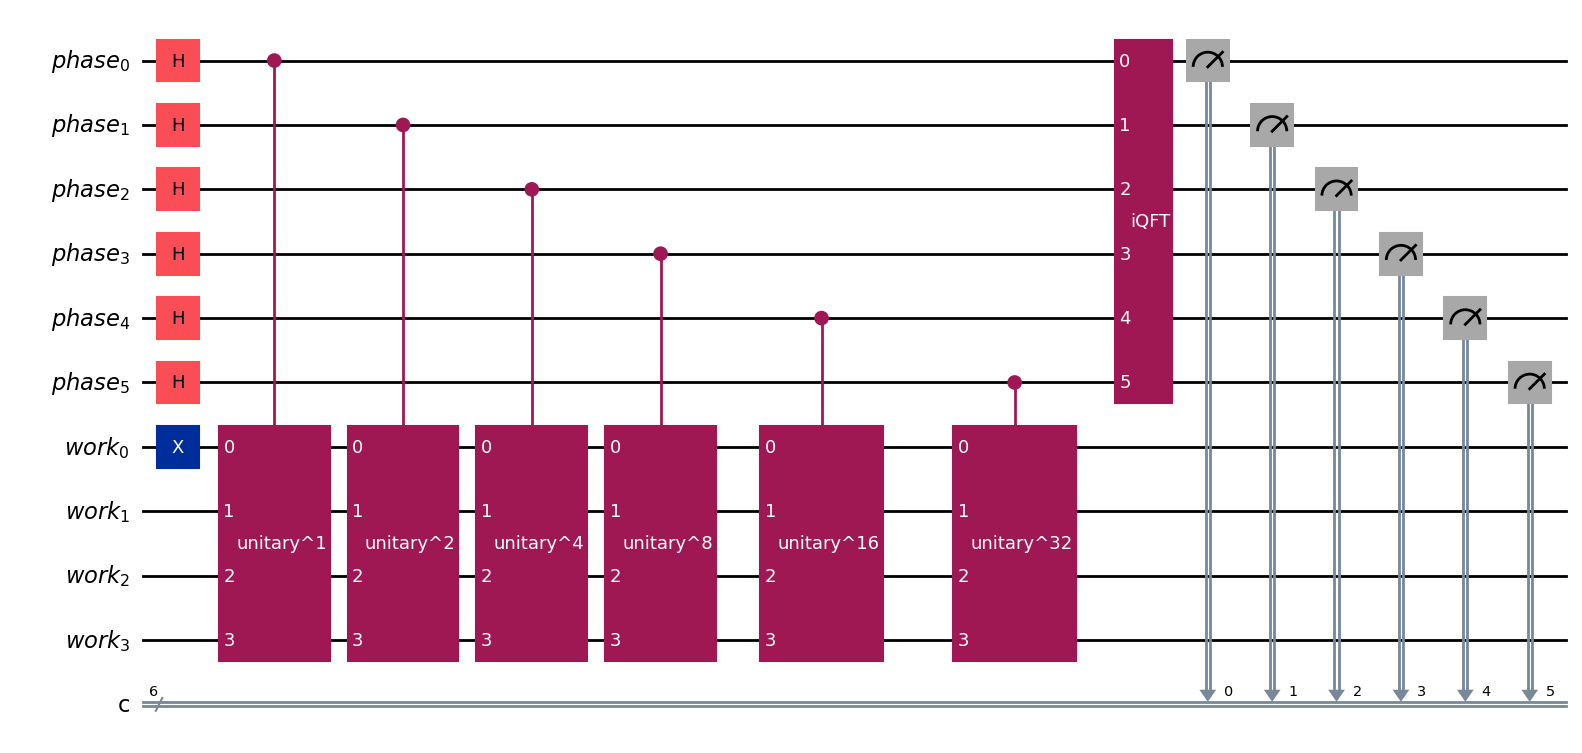

In [8]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT

def build_qpe_order_finding(a: int, N: int, t: int, n: int) -> QuantumCircuit:
    q_phase = QuantumRegister(t, "phase")
    q_work = QuantumRegister(n, "work")
    c_phase = ClassicalRegister(t, "c")
    qc = QuantumCircuit(q_phase, q_work, c_phase)

    qc.h(q_phase)          # superposición
    qc.x(q_work[0])        # |work> = |1>

    U = make_U_mul_mod_N(a, N, n)

    # controlled-U^(2^j)
    for j in range(t):
        qc.append(U.power(2**j).control(1), [q_phase[j]] + list(q_work))

    qc.append(QFT(t, inverse=True, do_swaps=True).to_gate(label="iQFT"), q_phase)
    qc.measure(q_phase, c_phase)

    return qc

t = 6
qc = build_qpe_order_finding(a, N, t, n)
qc.draw("mpl")


Cell 5 — (Optional but recommended) Quick “local mode” test with Aer

This is not your Aer notebook, but it helps verify that the circuit is still correct.

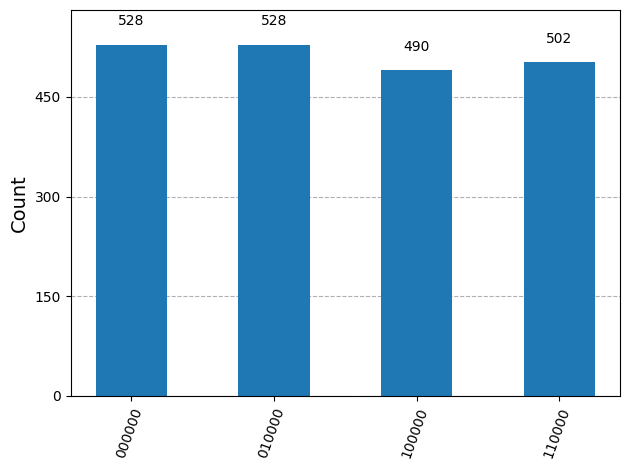

In [9]:
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.visualization import plot_histogram

shots_local = 2048
backend_local = AerSimulator()

tqc_local = transpile(qc, backend_local, optimization_level=1)
res_local = backend_local.run(tqc_local, shots=shots_local).result()
counts_local = res_local.get_counts()

plot_histogram(counts_local)


IBM Hardware section
Cell 6 — Login / Token (only if needed)

Si ya tienes cuenta guardada, puedes saltarte esto.

Dos opciones comunes:

Option A: Guardar token una vez (persistente)

In [12]:

my_api_key ="XXX"
my_crn = "WCEGTWERYEGT-YOUR-CRN"

from qiskit_ibm_runtime import QiskitRuntimeService

QiskitRuntimeService.save_account(
    channel="ibm_quantum_platform",
    token=my_api_key,
    instance=my_crn,
    name="name-your-instance",
    overwrite=True
)
service = QiskitRuntimeService(channel="ibm_quantum_platform")

Cell 7 — Choose a real backend (least_busy) with enough qubits

You need at least t + n qubits (phase + work). With t=6 and n=4 → 10 qubits.

In [13]:
min_qubits = t + n
print("Qubits requeridos:", min_qubits)

backend = service.least_busy(operational=True, simulator=False, min_num_qubits=min_qubits)
print("✅ Backend elegido:", backend.name)


Qubits requeridos: 10
✅ Backend elegido: ibm_torino


Cell 8 — Transpile for the backend (preset pass manager)

IBM recommends the approach using generate_preset_pass_manager.
IBM Quantum
+1

In [14]:
from qiskit.transpiler import generate_preset_pass_manager

opt_level = 1  # 1 o 2 suele ser razonable para hardware
pm = generate_preset_pass_manager(backend=backend, optimization_level=opt_level)

isa_qc = pm.run(qc)

print("✅ Transpilado listo.")
print("Depth (aprox):", isa_qc.depth())
print("2q gates (aprox):", isa_qc.count_ops().get("cx", 0))
#Si la profundidad se ve muy alta, baja t (por ejemplo t=5).

✅ Transpilado listo.
Depth (aprox): 3501
2q gates (aprox): 0


Cell 9 — Run on hardware with SamplerV2 + Session

SamplerV2 + Session are the recommended pattern

In [ ]:
# """ # leave here as example , but  done use,  dot going to run with current credencials
# from qiskit_ibm_runtime import Session
# from qiskit_ibm_runtime import SamplerV2 as Sampler

# shots_hw = 4000

# with Session(backend=backend) as session:
#     sampler = Sampler(mode=session)
#     job = sampler.run([isa_qc], shots=shots_hw)
#     result = job.result()

# pub = result[0]
# print("✅ Job completado.") """

##



This is the key fix: Sampler(mode=backend) instead of Sampler(mode=session)

In [15]:
# Esto es la corrección clave: Sampler(mode=backend) en lugar de Sampler(mode=session)
from qiskit_ibm_runtime import SamplerV2 as Sampler

shots_hw = 4000

# Open Plan: NO Session. Usa el backend como "mode" (job mode).
sampler = Sampler(mode=backend)

job = sampler.run([isa_qc], shots=shots_hw)
result = job.result()

pub = result[0]
print("✅ Job completado (job mode, sin Session).")
#Si la profundidad se ve muy alta, baja t (por ejemplo t=5).


✅ Job completado (job mode, sin Session).


Cell 10 — Get counts del resultado (¡importante!)

En SamplerV2, los counts suelen venir por nombre del registro clásico (en nuestro circuito es "c"), usando pub.data.<reg>.get_counts().

Esto coincide con la práctica descrita por la comunidad y cómo se expone BitArray.get_counts()

In [16]:
# En nuestro circuito usamos ClassicalRegister(t, "c")
counts_hw = pub.data.c.get_counts()

top_hw = sorted(counts_hw.items(), key=lambda kv: kv[1], reverse=True)
print("Top 10 outcomes (hardware):")
for s, c in top_hw[:10]:
    print(s, c)


Top 10 outcomes (hardware):
010100 362
110100 327
100100 289
000100 281
011100 226
111100 194
101100 175
001100 163
001110 99
011110 87


Cell 11 — Recover r from hardware + factor N

In [17]:
found = None
for bitstring, c in top_hw[:30]:
    r, y, phase, frac = recover_order_from_measurement(bitstring, t, a, N)
    if r is not None:
        found = (bitstring, c, r, y, phase, frac)
        break

print("Recovered:", found)

if found is None:
    print("❌ No se recuperó r. Sugerencias: subir shots, bajar t, o cambiar backend.")
else:
    bitstring, c, r, y, phase, frac = found
    factors = shor_postprocess(a, N, r)

    print(f"bitstring={bitstring}, count={c}")
    print(f"y={y}, y/2^t={phase}, approx={frac} -> r={r}")
    print("factors:", factors)


Recovered: ('010100', 362, 16, 20, 0.3125, Fraction(5, 16))
bitstring=010100, count=362
y=20, y/2^t=0.3125, approx=5/16 -> r=16
factors: None


Cell 12 — Practical loop: automatic retries (change t or shots)

On real hardware it is normal for it to fail sometimes. This loop makes 3 attempts.

In [18]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.transpiler import generate_preset_pass_manager

def run_hw_attempt(service, t_try=6, shots=4000, opt_level=1, a_try=2, N=15, n=4):
    # 1) Build QPE circuit
    qc_try = build_qpe_order_finding(a_try, N, t_try, n)

    # 2) Pick a backend with enough qubits
    backend_try = service.least_busy(operational=True, simulator=False, min_num_qubits=t_try + n)

    # 3) Transpile for that backend
    pm_try = generate_preset_pass_manager(backend=backend_try, optimization_level=opt_level)
    isa_try = pm_try.run(qc_try)

    # 4) Run in JOB MODE (Open plan): Sampler(mode=backend), NO Session
    sampler = Sampler(mode=backend_try)
    job = sampler.run([isa_try], shots=shots)
    result = job.result()
    pub = result[0]

    # 5) Extract counts
    counts = pub.data.c.get_counts()
    top = sorted(counts.items(), key=lambda kv: kv[1], reverse=True)

    # 6) Try to recover order r and factor
    for bitstring, c in top[:60]:
        r, y, phase, frac = recover_order_from_measurement(bitstring, t_try, a_try, N)
        if r is not None:
            fac = shor_postprocess(a_try, N, r)
            return {
                "backend": backend_try.name,
                "t": t_try,
                "a": a_try,
                "shots": shots,
                "depth": isa_try.depth(),
                "ops": dict(isa_try.count_ops()),
                "top": top[:10],
                "r": r,
                "bitstring": bitstring,
                "factors": fac
            }

    # If nothing recovered:
    return {
        "backend": backend_try.name,
        "t": t_try,
        "a": a_try,
        "shots": shots,
        "depth": isa_try.depth(),
        "ops": dict(isa_try.count_ops()),
        "top": top[:10],
        "r": None,
        "bitstring": None,
        "factors": None
    }


# --- run a few attempts ---
shots_hw = 4000
t = 6
a = 2
N = 15
n = 4

for attempt in range(1, 4):
    out = run_hw_attempt(service, t_try=t, shots=shots_hw, opt_level=1, a_try=a, N=N, n=n)
    print("\nAttempt", attempt)
    print("backend:", out["backend"], "| t:", out["t"], "| a:", out["a"], "| depth:", out["depth"])
    print("r:", out["r"], "| factors:", out["factors"])
    print("top10:", out["top"])
    if out["factors"] is not None:
        break


C:\Users\caraq\AppData\Local\Temp\ipykernel_25660\459924058.py:19: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(t, inverse=True, do_swaps=True).to_gate(label="iQFT"), q_phase)



Attempt 1
backend: ibm_torino | t: 6 | a: 2 | depth: 3418
r: 4 | factors: (3, 5)
top10: [('100000', 660), ('010000', 650), ('000000', 650), ('110000', 584), ('100010', 83), ('010010', 75), ('000010', 74), ('110010', 65), ('100100', 60), ('010100', 60)]


Two quick tweaks that help a lot on hardware
1) Try multiple a values automatically

For N=15, good choices: a in [2, 7, 11, 13] (all coprime).

You can wrap that loop like this:

In [22]:
for a_try in [2, 7, 11, 13]:
    out = run_hw_attempt(service, t_try=6, shots=6000, opt_level=1, a_try=a_try, N=15, n=4)
    print("\na:", a_try, "-> r:", out["r"], "factors:", out["factors"], "backend:", out["backend"])
    if out["factors"] is not None:
        break


C:\Users\caraq\AppData\Local\Temp\ipykernel_25684\459924058.py:19: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(t, inverse=True, do_swaps=True).to_gate(label="iQFT"), q_phase)



a: 2 -> r: 4 factors: (3, 5) backend: ibm_torino
